# Patrones de Carga de Vehículos Eléctricos — Clustering de Usuarios

Este cuaderno analiza patrones de carga de vehículos eléctricos mediante clustering (aprendizaje no supervisado). Buscamos identificar segmentos según ubicación (Home, Work, Other/Public), energía (kWh) y duración/horario de las sesiones.

Qué vas a ver:
- Importación y exploración inicial del dataset.
- Ingeniería de variables relevantes (duración, hora de inicio, medias de consumo, etc.).
- Escalado de variables y aplicación de K-Means.
- Visualizaciones e interpretación por ubicación.

Cómo reproducir:
1. Crea un entorno virtual y activa.
2. Instala dependencias desde `requirements.txt`.
3. Ejecuta las celdas de arriba a abajo.

Última edición: 2025-08-10.

# EJERCICIO EV_Charging_User # Aprendizaje no supervisado: Clustering. ## *Patrones de consumo por ubicación*

En el aprendizaje no supervisado, la tarea clásica es el **análisis de clusters** (grupos) en el que se encuentran patrones o grupos ocultos en los datos. La mayoría de las veces las tareas de aprendizaje no supervisado tienen una *solución abierta*, por lo que hay que interpretar los resultados y comprobar si tienen sentido.

**Objetivo:** En este ejemplo, se realizará un clustering de datos sobre usuarios que utilizan cargadores electricos.Vamos a intentar encontrar un patrón de consumo por ubicaciónes.

## **1. Importar librerías y datos**

In [1]:
# Importar librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


## **2. Comprender los datos** 
Es necesario visualizar y comprender los datos con los que vamos a trabajar, así como conocer sus características.
1. ¿Cuántos datos hay? ¿Cuántos atributos hay en los datos? 
2. ¿Qué significan?
3. Resumen estadístico del conjunto de datos de entrada.
4. ¿Falta algún dato?


## Importación de datos

Cargamos el dataset y realizamos una inspección rápida para validar el formato.

## Exploración rápida

Primer vistazo al contenido: primeras y últimas filas, dimensiones y tipos.

In [166]:
# Primera visualización del dataset
df_clientes = pd.read_csv('Data/EV_Charging_User_Dataset.csv', sep=",")
df_clientes.head()

,user_id,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week,location
0,user_night_0,22.496714,6.398293,22.604129,6,home
1,user_night_1,21.861736,8.852278,24.071705,6,home
2,user_night_2,22.647689,6.986503,19.468325,7,home
3,user_night_3,23.000000,5.942289,19.018967,6,home
4,user_night_4,21.765847,7.822545,29.062629,7,home


**1. ¿Cuántos datos hay? ¿Cuántos atributos hay en los datos?**

In [167]:
# Dimensión de los datos de entrada (filas x columnas)
df_clientes.shape# Nos dice las filas 

(120, 6)

In [168]:
# Ya hemos visto el "head", vamos a ver el "tail"
df_clientes.tail()

,user_id,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week,location
115,user_work_25,8.766297,7.713653,24.148634,4,work
116,user_work_26,9.044351,8.045608,18.761028,4,work
117,user_work_27,7.823873,8.389180,15.320732,5,work
118,user_work_28,9.445507,7.732599,19.568060,4,work
119,user_work_29,7.538243,7.896159,26.108405,4,work


**2. ¿Qué significan?**

In [169]:
# También podemos obtener el nombre de las columnas
df_clientes.columns

Index(['user_id', 'avg_start_hour', 'avg_duration_h', 'avg_energy_kWh',
       'sessions_per_week', 'location'],
      dtype='object')

In [170]:
# Se comprueba el tipo de variable de cada columna
df_clientes.dtypes

user_id               object
avg_start_hour       float64
avg_duration_h       float64
avg_energy_kWh       float64
sessions_per_week      int64
location              object
dtype: object

**3. Resumen estadístico del conjunto de datos de entrada:** La estadística descriptiva recolecta y analiza el conjunto de datos de entrada con el objetivo de describir las características y comportamientos de este conjunto mediante las siguientes medidas resumen: número total de observaciones (count), media (mean), desviación estándar (std), valor mínimo (min), valor máximo (max) y los valores de los diferentes cuartiles (25%, 50%, 75%).

In [171]:
# Evaluamos la naturaleza de los datos con datos estadísticos descriptivos utilizo round para quitarle decimales 
df_clientes.describe().round(2)

,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week
count,120.00,120.00,120.00,120.00
mean,13.84,5.11,20.59,5.38
std,5.26,2.64,10.15,3.33
min,7.00,0.53,3.11,1.00
25%,9.60,2.33,12.00,3.50
50%,11.93,5.63,20.76,5.00
75%,19.96,7.33,26.83,7.00
max,23.00,9.86,45.61,13.00


**4. ¿Falta algún dato?** Se comprueba si falta algún dato, y de ser así, se realiza el recuento de celdas vacías en cada atributo.

In [172]:
df_clientes['location'].unique()# veo que tipo de objetos hay en location (home mixed or work )
df_clientes['location'].value_counts()# Con value_counts() cuento de cada tipo cuantas tengo 
df_clientes.isna().sum() #Obesevo si falta algun dato
#df_clientes.isnull()# Nos dice si es nulo o no 


user_id              0
avg_start_hour       0
avg_duration_h       0
avg_energy_kWh       0
sessions_per_week    0
location             0
dtype: int64

## **3. Limpieza de datos** 
Antes de empezar a trabajar con los datos, estos se tienen que limpiar (anteriormente ya se han eliminado los NaNs) y transformar en otros features en caso de ser necesario

In [173]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            120 non-null    object 
 1   avg_start_hour     120 non-null    float64
 2   avg_duration_h     120 non-null    float64
 3   avg_energy_kWh     120 non-null    float64
 4   sessions_per_week  120 non-null    int64  
 5   location           120 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 5.8+ KB


De la función `df_clientes.info()` vemos que no tenemos ningun valor nulo, aunque en la columna 'Income' tenemos 2216 muestras en vez de 2240. También vemos que la columna 'Dt_Customer' está en formato `object` en vez de `DateTime` y que hay 2 columnas más con formato `object`, en las cuales tendremos que codificar para que el código pueda entenderlas.

**¿Qué hacemos con los NaN?** 
En este caso no se observa ningun Nan

In [2]:
df_clientes


NameError: name 'df_clientes' is not defined

In [175]:
df_clean=df_clientes.copy() #Creo una copia para evitar modificar el inicial 
df_clean.dtypes


user_id               object
avg_start_hour       float64
avg_duration_h       float64
avg_energy_kWh       float64
sessions_per_week      int64
location              object
dtype: object

**Las columnas con formato *object* son datos categóricos y tienen que tranformarse a valores numéricos**. ¿Cómo lo hacemos?

In [176]:
print("Total categories in the feature location:\n", df_clean["location"].value_counts(), "\n")
print("Total categories in the feature user:id:\n", df_clean["user_id"].value_counts())

Total categories in the feature location:
 home     60
mixed    30
work     30
Name: location, dtype: int64 

Total categories in the feature user:id:
 user_night_0            1
user_night_1            1
user_weekend_28         1
user_weekend_27         1
user_weekend_26         1
                       ..
user_opportunistic_5    1
user_opportunistic_4    1
user_opportunistic_3    1
user_opportunistic_2    1
user_work_29            1
Name: user_id, Length: 120, dtype: int64


***Marital_Status.*** Opciones:
- Integer encoding.
- One-hot encoding (en 1 o múltiples columnas).

In [177]:
# Primero reducimos el Martial_Status a 2 variables (pareja/solo)
#df_clean["Living_With"]=df_clean["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

# Ahora hacemos one-hot encoding creando la columna 'Partner'
df_clean["location_num"] = df_clean['location'].map({"home": 0, "work":1, 'mixed':2})
df_clean

#Eliminar columna location
df_clean.drop(columns=['location'], inplace=True)
df_clean
#df_clean.dptypes

,user_id,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week,location_num
0,user_night_0,22.496714,6.398293,22.604129,6,0
1,user_night_1,21.861736,8.852278,24.071705,6,0
2,user_night_2,22.647689,6.986503,19.468325,7,0
3,user_night_3,23.000000,5.942289,19.018967,6,0
4,user_night_4,21.765847,7.822545,29.062629,7,0
...,...,...,...,...,...,...
115,user_work_25,8.766297,7.713653,24.148634,4,1
116,user_work_26,9.044351,8.045608,18.761028,4,1
117,user_work_27,7.823873,8.389180,15.320732,5,1
118,user_work_28,9.445507,7.732599,19.568060,4,1


 ## **4.visualizar los datos** 
 
**4.1. Histograma**

Respresentación gráfica de cada uno de los atributos en forma de barras, donde la superficie de la barra es proporcional a la frecuencia de los valores representados.

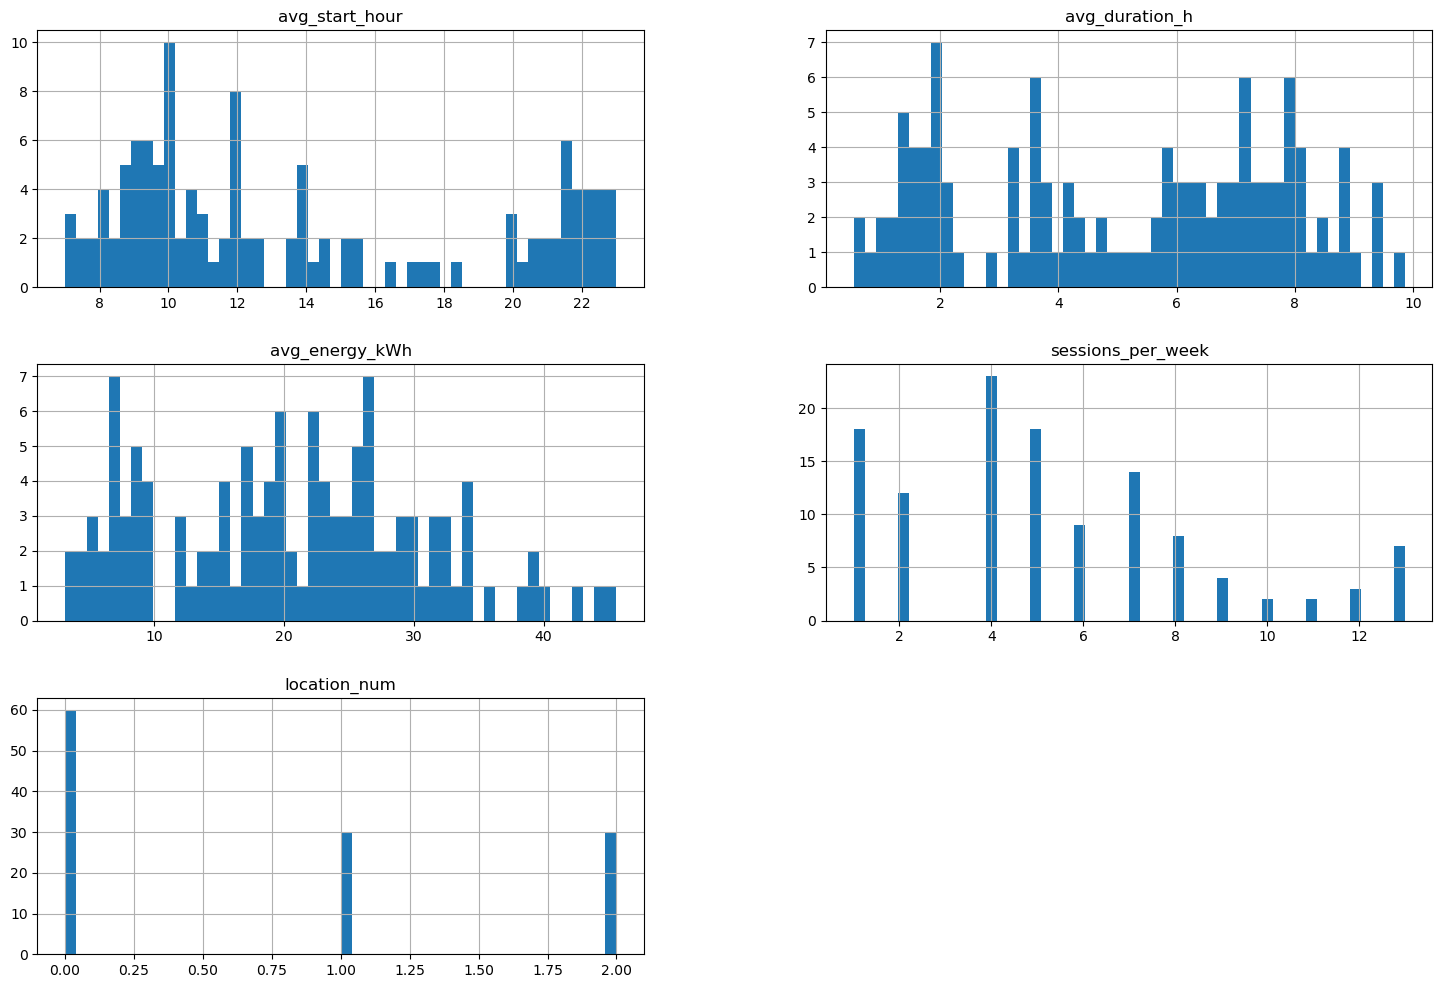

In [178]:
histograma = df_clean.hist(xlabelsize=10, ylabelsize=10, bins=50, figsize=(18, 12))#El xlabelsize(es coje el tamaño de fuente del ejes x e y)

**4.2.Box Plot**

Realizado un graficas de box plot para cada columna para ver si tengo algun outlier, que deberia elimnar. No veo ninguno asi que continuo con el esutido.

In [6]:
boxplot = df_clean.boxplot(column=['avg_start_hour','avg_duration_h','avg_energy_kWh','sessions_per_week','location_num'])

NameError: name 'df_clean' is not defined

**4.3.Matriz de correlación**

Ahora, vamos a mirar la correlación entre variables (excluyendo los atributos categoricos).


In [4]:

corrmat= df_clean.corr(numeric_only=True)#Importante en breves si no pones numeric_only=True) tambien te intentara coger variabels que no sean numericas
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)

SyntaxError: invalid syntax (2214839381.py, line 1)

## *5. Procesamiento de los datos* 


**5.1. Encoding para las variables categóricas**.

In [181]:
# Obtener lista de variables categóricas
cat = (df_clean.dtypes == 'object')
cols_cat = list(cat[cat].index)
cols_cat

print("Variables categoricas en el dataset:", cols_cat)

Variables categoricas en el dataset: ['user_id']


**5.2. Escalar los datos**. Se escalan los datos utilizando el método de *StandardScaler()*

In [182]:
from sklearn.preprocessing import StandardScaler
df_final = df_clean.copy()
df_final=df_clean[['avg_start_hour','avg_duration_h','avg_energy_kWh','sessions_per_week','location_num']]
scaler = StandardScaler()
X = df_final.copy()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_scale

,0,1,2,3,4
0,1.652452,0.491118,0.199554,0.188436,-0.904534
1,1.531251,1.424383,0.344752,0.188436,-0.904534
2,1.681269,0.714817,-0.110695,0.489933,-0.904534
3,1.748517,0.317696,-0.155153,0.188436,-0.904534
4,1.512948,1.032769,0.838540,0.489933,-0.904534
...,...,...,...,...,...
115,-0.968339,0.991357,0.352363,-0.414558,0.301511
116,-0.915265,1.117601,-0.180673,-0.414558,0.301511
117,-1.148224,1.248264,-0.521046,-0.113061,0.301511
118,-0.838694,0.998562,-0.100827,-0.414558,0.301511


## 6. Construcción del modelo de aprendizaje NO supervisado: Clustering de consumos utilizando K-means

Se agrupan los datos utilizando el algoritmo [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). El algoritmo K-means necesita que se le indique el número de clústers en que se quieren agrupar los datos. Se ejecuta el algoritmo para varios clusters y luego se comparan los resultados utilizando el método Elbow, que indicará el número óptimo de clusters.

### ¿Cómo saber el número óptimo de clusters? Con el método de Elbow.
Se utiliza el [Método de Elbow] para ayudarnos a elegir el número óptimo de clusters. * Este método utiliza los valores de la inercia obtenidos tras aplicar el K-means a diferente número de clusters (desde 1 a N clusters), siendo la inercia la suma de las distancias al cuadrado de cada objeto del cluster a su centroide.
* Para hacer uso de este método partimos del cálculo de la distorsión promedio de cada clúster, esto es la distancia de cada elemento con su centroide correspondiente.
* Buscamos la parte de la gráfica donde la línea es menos suave o cambia abruptamente lo que forma un “codo”. [Método de Elbow]: https://jarroba.com/seleccion-del-numero-optimo-clusters/

## Clustering K-Means

Agrupamos sesiones/usuarios en función de sus rasgos de consumo y horario.

In [183]:
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
os.environ["OMP_NUM_THREADS"] = "1"

elbow_method = [] 

# Evalúo el algoritmo K-means para un rango de [1,15] clústers 
n_cluster_list = range(1,15)

C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

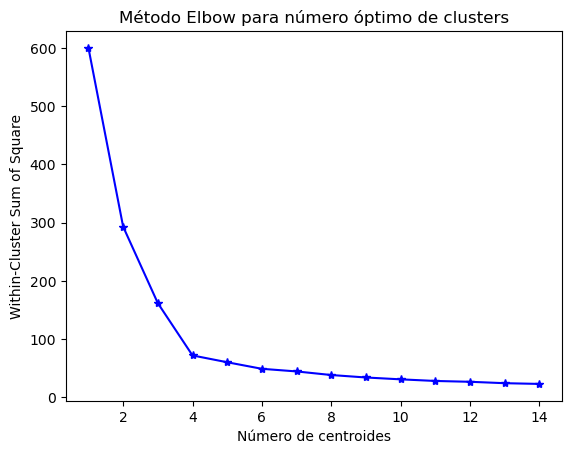

In [184]:
import matplotlib.pyplot as plt

# Iteración para evaluar K-means para diferentes números de clusters (n_clusters)
for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster, random_state=0,n_init=10)
    cluster_found = kmeans.fit_predict(X_scale)
    elbow_method.append(kmeans.inertia_) 


# Gráfica del método de Elbow
plt.plot(n_cluster_list, elbow_method, 'b', marker='*')
plt.xlabel('Número de centroides')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('Método Elbow para número óptimo de clusters')
plt.show()

# El número óptimo de clusters es de k=4

In [185]:
# Entreno el K-means para k=4, visto el resultado del método Elbow
kmeans = KMeans(n_clusters=4)
cluster_found = kmeans.fit_predict(X_scale)

df_cluster_def = df_final.copy()
df_cluster_def['cluster'] = pd.Series(cluster_found)
df_cluster_def

C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week,location_num,cluster
0,22.496714,6.398293,22.604129,6,0,2
1,21.861736,8.852278,24.071705,6,0,2
2,22.647689,6.986503,19.468325,7,0,2
3,23.000000,5.942289,19.018967,6,0,2
4,21.765847,7.822545,29.062629,7,0,2
...,...,...,...,...,...,...
115,8.766297,7.713653,24.148634,4,1,3
116,9.044351,8.045608,18.761028,4,1,3
117,7.823873,8.389180,15.320732,5,1,3
118,9.445507,7.732599,19.568060,4,1,3


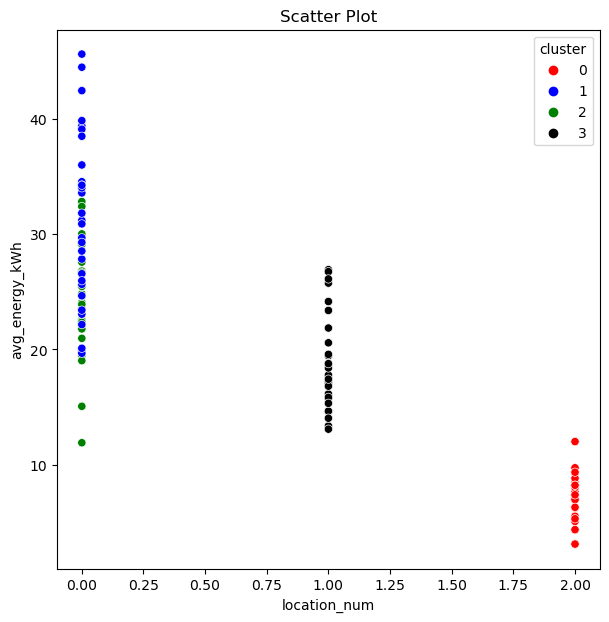

In [186]:
color_dict = {0: 'red', 1: 'blue', 2: 'green',3:'black'}#defino el color de los puntos que quiero en el Scatter
plt.figure(figsize=(7,7))
sns.scatterplot(x=df_cluster_def["location_num"], y=df_cluster_def["avg_energy_kWh"], hue=df_cluster_def["cluster"],palette=color_dict)

# Estética del plot
plt.title('Scatter Plot', fontsize=12)
plt.xlabel('location_num', fontsize=10)
plt.ylabel('avg_energy_kWh', fontsize=10)

plt.show()


K-means ha encontrado cuatro clúster con las siguientes características, mirando la gráfica anterior:
* Observo que la gente que carga desde casa tien un consumo bastante variable pero mayor que si cargan en el trabajo o mixto
* mixto tien un consumo bastante mas bajo.

### Extra: Encontrar el número óptimo de clústers mediante el Silhouette Score

In [187]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Evalúo el algoritmo K-means para un rango de [2,15] clústers 
n_cluster_list = range(2,15)

C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\aleoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

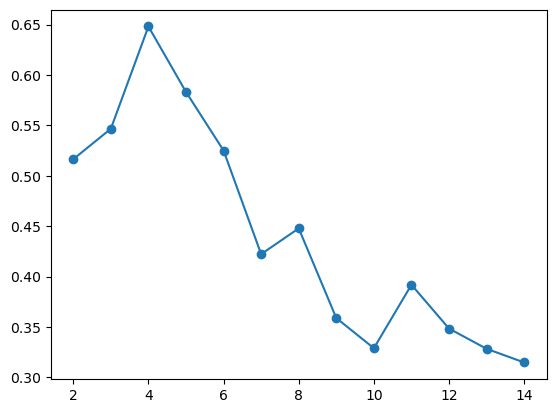

In [188]:
for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_found = kmeans.fit_predict(X_scale)
    silhouette_scores.append(silhouette_score(X_scale, kmeans.labels_, random_state=0))

silhouette_metric = pd.DataFrame(index=n_cluster_list, columns=['silhouette_score'], data=silhouette_scores)
plt.plot(silhouette_metric, marker='o')

## Validar los resultados con Dimensionality Reduction (PCA)
Principal Component Analysis (PCA) es un método estadístico que permite simplificar la complejidad de espacios muestrales con muchas dimensiones a la vez que conserva su información. En este caso, podemos trabajar con el dataset original (previo a reducirlo), ya que con este método se reducen las "features" conservando el máximo de información. Repetimos los pasos seguidos anteriormente pero con todas las variables. Una forma de validar los resultados del algoritmo clustering es mediante técnicas de dimensionality reduction. Hay que tener en cuenta es que el PCA no sabe nada de los grupos encontrados por K-means.

In [189]:
df_final.head()

,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week,location_num
0,22.496714,6.398293,22.604129,6,0
1,21.861736,8.852278,24.071705,6,0
2,22.647689,6.986503,19.468325,7,0
3,23.000000,5.942289,19.018967,6,0
4,21.765847,7.822545,29.062629,7,0


In [190]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df_final.values.copy()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_scale

,0,1,2,3,4
0,1.652452,0.491118,0.199554,0.188436,-0.904534
1,1.531251,1.424383,0.344752,0.188436,-0.904534
2,1.681269,0.714817,-0.110695,0.489933,-0.904534
3,1.748517,0.317696,-0.155153,0.188436,-0.904534
4,1.512948,1.032769,0.838540,0.489933,-0.904534
...,...,...,...,...,...
115,-0.968339,0.991357,0.352363,-0.414558,0.301511
116,-0.915265,1.117601,-0.180673,-0.414558,0.301511
117,-1.148224,1.248264,-0.521046,-0.113061,0.301511
118,-0.838694,0.998562,-0.100827,-0.414558,0.301511


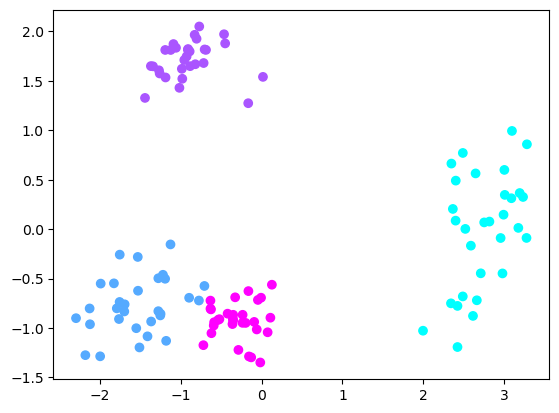

In [191]:
from sklearn.decomposition import PCA
import matplotlib.colors

pca = PCA(n_components=2)
results_pca = pca.fit_transform(X_scale)

plt.scatter(results_pca[:, 0], results_pca[:, 1],
            c = df_cluster_def['cluster'],
            cmap = 'cool'
            )
plt.show()

Creo entender que el cluster seria correcto con el PDCA veo que hay 4 cluster bastante diferencuiados, tal y como habiamos encontrado.

me surge una duda y es porque en home hay dos cluster, y uno en especial se le dispara el consumo de kwh. Voy a intentar ver que pasa en estos 2 clusters .

## Análisis por ubicación

Comparamos resultados y distribuciones por Home, Work y Other/Public.

In [197]:

df_home = df_cluster_def[df_cluster_def['location_num'] == 0]  # Filtrar por "home"
df_home

,avg_start_hour,avg_duration_h,avg_energy_kWh,sessions_per_week,location_num,cluster
0,22.496714,6.398293,22.604129,6,0,2
1,21.861736,8.852278,24.071705,6,0,2
2,22.647689,6.986503,19.468325,7,0,2
3,23.000000,5.942289,19.018967,6,0,2
4,21.765847,7.822545,29.062629,7,0,2
5,21.765863,5.779156,31.781200,5,0,2
6,23.000000,7.208864,24.639949,7,0,2
7,22.767435,5.040330,30.017664,6,0,2
8,21.530526,5.671814,26.808180,5,0,2
9,22.542560,7.196861,21.774401,5,0,2


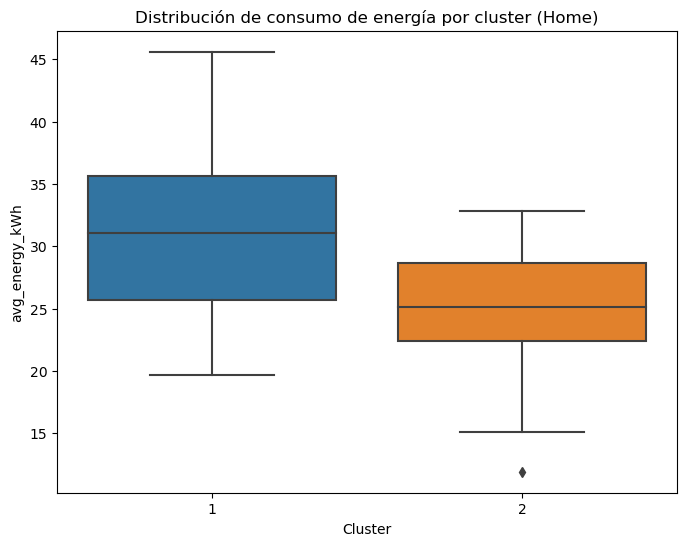

In [203]:
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster', y='avg_energy_kWh', data=df_home)
plt.title('Distribución de consumo de energía por cluster (Home)')
plt.xlabel('Cluster')
plt.ylabel('avg_energy_kWh')
plt.show()


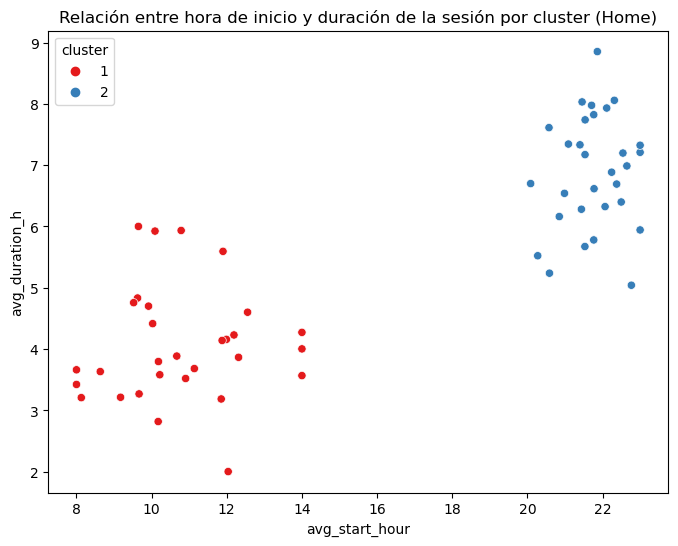

In [205]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_start_hour', y='avg_duration_h', hue='cluster', data=df_home, palette='Set1')
plt.title('Relación entre hora de inicio y duración de la sesión por cluster (Home)')
plt.xlabel('avg_start_hour')
plt.ylabel('avg_duration_h')
plt.show()


## 7.Conlusiones

Sacando la relacion de la media de energía que se consume para cada cluster respecto la ubicación donde se carga. Observo que hay un grupo grande que prefiere cargar en casa, pero dentro de casa hay 2 cluster, analizando un poco mas se observa que el cliente home tiene dos preferencias cargar por la mañana o por la noche. Cuando carga por la mañana carga menos horas y por la noche carga casi toda la noche: Seria interesante quizas hacer algun tipo de oferta para los que cargan en home en horario diurno, un cargador mas rápido para poder en menos tiempo tener el coche con su máxima carga. Mientras, que para los que cargan por la noche algún tipo de tarifa mas reducida.
